# Inspect Trained Models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path

import numpy as np
from PIL import Image
import numpy as np
import os
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.datasets.utils as dataset_utils

from gendis.datasets import CausalMNIST, ClusteredMultiDistrDataModule
from gendis.model import NeuralClusteredASCMFlow

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
seed = 2
graph_type = 'chain'
# Sub this model filename in when we support it and run new models
model_fname = f"{graph_type}-seed={seed}-model.pt"

results_dir = Path(f'/Users/adam2392/pytorch_data/data/chain-seed={seed}/')
model = torch.load(results_dir / model_fname, map_location=torch.device('cpu'))

In [106]:
# get the images
graph_type = 'chain'
root = '/Users/adam2392/pytorch_data/'

dataset = CausalMNIST(root=root, graph_type=graph_type, label=0, download=True, train=True, n_jobs=None, intervention_idx=None)
dataset.prepare_dataset(overwrite=False)

img, metadata = dataset[0]
print(img.shape)

Loading dataset from "/Users/adam2392/pytorch_data/CausalMNIST/chain/chain-0-train.pt"
torch.Size([3, 28, 28]) {'width': tensor([0.5344]), 'color': tensor([0.3977]), 'fracture_thickness': tensor([8.9378]), 'fracture_num_fractures': tensor([1.]), 'label': 0, 'intervention_targets': [0, 0, 0]}
torch.Size([3, 28, 28])


In [145]:
import normflows as nf

# set up transforms for each image to augment the dataset
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        nf.utils.Jitter(1 / 256.0),  # apply random generation
        nf.utils.Scale(255.0 / 256.0),  # normalize the pixel values
        nf.utils.Scale(1. / 256.0),  # normalize the pixel values
        torchvision.transforms.RandomRotation(350),  # get random rotations
    ]
)

# load dataset
datasets = []
intervention_targets_per_distr = []
hard_interventions_per_distr = None
num_distrs = 0
for intervention_idx in [None, 1, 2, 3]:
    dataset = CausalMNIST(
        root=root,
        graph_type=graph_type,
        label=0,
        download=True,
        train=True,
        n_jobs=None,
        intervention_idx=intervention_idx,
        transform=transform,
    )
    dataset.prepare_dataset(overwrite=False)
    datasets.append(dataset)
    num_distrs += 1
    intervention_targets_per_distr.append(dataset.intervention_targets)


Loading dataset from "/Users/adam2392/pytorch_data/CausalMNIST/chain/chain-0-train.pt"
torch.Size([3, 28, 28]) {'width': tensor([0.5344]), 'color': tensor([0.3977]), 'fracture_thickness': tensor([8.9378]), 'fracture_num_fractures': tensor([1.]), 'label': 0, 'intervention_targets': [0, 0, 0]}
Loading dataset from "/Users/adam2392/pytorch_data/CausalMNIST/chain/chain-1-train.pt"
torch.Size([3, 28, 28]) {'width': tensor([4.0281]), 'color': tensor([0.3975]), 'fracture_thickness': tensor([9.4378]), 'fracture_num_fractures': tensor([1.]), 'label': 0, 'intervention_targets': [1, 0, 0]}
Loading dataset from "/Users/adam2392/pytorch_data/CausalMNIST/chain/chain-2-train.pt"
torch.Size([3, 28, 28]) {'width': tensor([0.4431]), 'color': tensor([0.4416]), 'fracture_thickness': tensor([10.2519]), 'fracture_num_fractures': tensor([0.]), 'label': 0, 'intervention_targets': [0, 0, 1]}
Loading dataset from "/Users/adam2392/pytorch_data/CausalMNIST/chain/chain-3-train.pt"
torch.Size([3, 28, 28]) {'width':

In [146]:
# now we can wrap this in a pytorch lightning datamodule
data_module = ClusteredMultiDistrDataModule(
    datasets=datasets,
    num_workers=2,
    batch_size=16,
    intervention_targets_per_distr=intervention_targets_per_distr,
    log_dir='./',
    flatten=False,
)
data_module.setup()

torch.Size([23692, 3, 28, 28]) 6 torch.Size([23692]) torch.Size([23692]) torch.Size([23692])


tensor(42.) tensor(142.)
tensor(0.) tensor(142.)
tensor(0.) tensor(136.)
tensor(0.) tensor(143.)
tensor(0.) tensor(142.)
tensor(0.) tensor(148.)
tensor(0.) tensor(141.)
tensor(0.) tensor(185.)
tensor(0.) tensor(142.)
tensor(0.) tensor(141.)
tensor(0.) tensor(141.)
tensor(0.) tensor(142.)
tensor(0.) tensor(142.)
tensor(0.) tensor(186.)
tensor(0.) tensor(141.)
tensor(0.) tensor(142.)


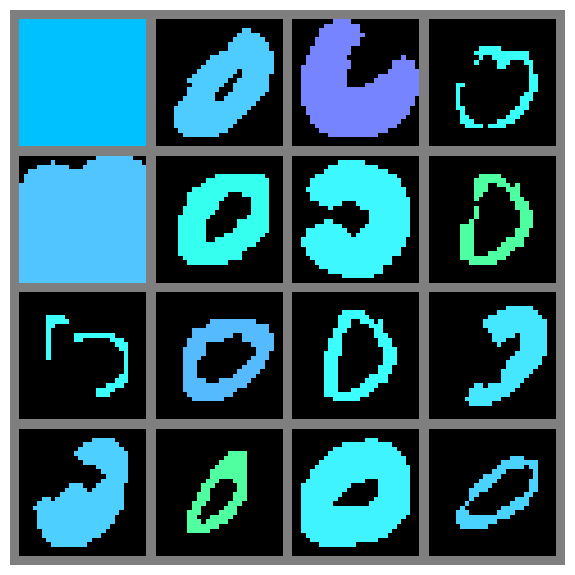

In [149]:

(imgs, width,
        color,
        fracture_thickness,
        fracture_num_fractures,
        label,
        distr_indicators,
        intervention_targets,
    ) = next(iter(data_module.train_dataloader()))

# new_obs_imgs = imgs
new_obs_imgs = torch.zeros_like(imgs)
for idx, image in enumerate(imgs):
    print(image.min(), image.max())
    image = (image - image.min()) / (image.max() - image.min())
    new_obs_imgs[idx, ...] = image

show_imgs(new_obs_imgs)

In [144]:
print(imgs[0].flatten().max(), imgs[0].flatten().min())

tensor(143.) tensor(0.)


# Demo Trained Model Reproducing Images

Here, we are interested in qualitatively analyzing the trained model. This will entail

In [130]:
print([img.shape for img in imgs])

[torch.Size([5, 3, 28, 28]), torch.Size([5, 3, 28, 28]), torch.Size([5, 3, 28, 28]), torch.Size([5, 3, 28, 28]), torch.Size([5, 3, 28, 28])]


In [9]:
import math
import torchvision

def show_imgs(imgs, title=None, row_size=4):
    # Form a grid of pictures (we use max. 8 columns)
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    is_int = imgs.dtype==torch.int32 if isinstance(imgs, torch.Tensor) else imgs[0].dtype==torch.int32
    nrow = min(num_imgs, row_size)
    ncol = int(math.ceil(num_imgs/nrow))
    imgs = torchvision.utils.make_grid(imgs, nrow=nrow, pad_value=128 if is_int else 0.5)
    np_imgs = imgs.cpu().numpy()
    # Plot the grid
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(np.transpose(np_imgs, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.show()
    plt.close()

In [95]:
# sample from the trained encoder
encoder = model.encoder
print(encoder.causalq0)

NonparametricClusteredCausalDistribution(
  (q0): MultiEnvBaseDistribution()
  (flows): ModuleList(
    (0-2): 3 x AutoregressiveRationalQuadraticSpline(
      (mprqat): MaskedPiecewiseRationalQuadraticAutoregressive(
        (autoregressive_net): MADE(
          (preprocessing): Identity()
          (initial_layer): MaskedLinear(in_features=2352, out_features=128, bias=True)
          (blocks): ModuleList(
            (0-2): 3 x MaskedResidualBlock(
              (linear_layers): ModuleList(
                (0-1): 2 x MaskedLinear(in_features=128, out_features=128, bias=True)
              )
              (activation): ReLU()
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=128, out_features=54096, bias=True)
        )
      )
    )
  )
)


In [94]:
print(encoder.sample()[0].shape)

TypeError: BaseDistribution.sample() takes from 1 to 2 positional arguments but 3 were given

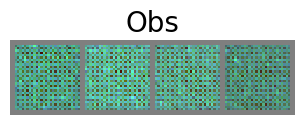

In [69]:
obs_imgs = encoder.sample(num_samples=4)[0]

new_obs_imgs = torch.zeros_like(obs_imgs)
for idx, image in enumerate(obs_imgs):
    image = (image - image.min()) / (image.max() - image.min())
    new_obs_imgs[idx, ...] = image
    
show_imgs(new_obs_imgs, title='Obs')

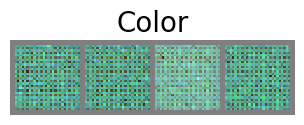

In [70]:
obs_imgs = encoder.sample(num_samples=4, intervention_targets=torch.Tensor([0, 0, 1]))[0]

new_obs_imgs = torch.zeros_like(obs_imgs)
for idx, image in enumerate(obs_imgs):
    image = (image - image.min()) / (image.max() - image.min())
    new_obs_imgs[idx, ...] = image
    
show_imgs(new_obs_imgs, title='Color')

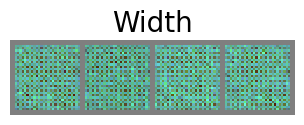

In [72]:
obs_imgs = encoder.sample(num_samples=4, intervention_targets=torch.Tensor([1, 0, 0]))[0]

new_obs_imgs = torch.zeros_like(obs_imgs)
for idx, image in enumerate(obs_imgs):
    image = (image - image.min()) / (image.max() - image.min())
    new_obs_imgs[idx, ...] = image
    
show_imgs(new_obs_imgs, title='Width')

# Load a Checkpoint and see

In [98]:
seed=2
graph_type='chain'
epoch=408
step=8589
results_dir = Path(f'/Users/adam2392/pytorch_data/data/{graph_type}-seed={seed}/')
checkpoint_fname = results_dir / f'epoch={epoch}-step={step}.ckpt'
model = NeuralClusteredASCMFlow.load_from_checkpoint(checkpoint_fname)

/Users/adam2392/miniforge3/envs/cdrl/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
  rank_zero_warn(


In [101]:
encoder= model.encoder

print(encoder.causalq0)

ClusteredCausalDistribution(
  (coeff_values): ParameterList(
      (0): Object of type: ParameterList
      (1): Object of type: ParameterList
      (2): Object of type: ParameterList
    (0): ParameterList(  (0): Parameter containing: [torch.float32 of size 784])
    (1): ParameterList(
        (0): Parameter containing: [torch.float32 of size 784]
        (1): Parameter containing: [torch.float32 of size 784]
    )
    (2): ParameterList(
        (0): Parameter containing: [torch.float32 of size 784]
        (1): Parameter containing: [torch.float32 of size 784]
    )
  )
  (noise_means): ParameterList(
      (0): Object of type: ParameterList
      (1): Object of type: ParameterList
      (2): Object of type: ParameterList
      (3): Object of type: ParameterList
    (0): ParameterList(
        (0): Parameter containing: [torch.float32 of size 784]
        (1): Parameter containing: [torch.float32 of size 784]
        (2): Parameter containing: [torch.float32 of size 784]
    )
   

In [103]:
# run a test to make sure this actually works
rand_img = torch.arange(28*28*3, dtype=torch.float32).view(1, 3, 28, 28)
out = encoder.forward(rand_img)
print(encoder.inverse_and_log_det(rand_img)[0].shape)

torch.Size([1, 2352])


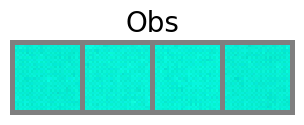

In [104]:
obs_imgs = encoder.sample(num_samples=4)[0]

new_obs_imgs = torch.zeros_like(obs_imgs)
for idx, image in enumerate(obs_imgs):
    image = (image - image.min()) / (image.max() - image.min())
    new_obs_imgs[idx, ...] = image
    
show_imgs(new_obs_imgs, title='Obs')

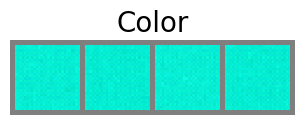

In [105]:
obs_imgs = encoder.sample(num_samples=4, intervention_targets=torch.Tensor([0, 0, 1]))[0]

new_obs_imgs = torch.zeros_like(obs_imgs)
for idx, image in enumerate(obs_imgs):
    image = (image - image.min()) / (image.max() - image.min())
    new_obs_imgs[idx, ...] = image
    
show_imgs(new_obs_imgs, title='Color')

# VAE Inspection

In [6]:
import torch.nn as nn
import torchvision

In [7]:

class Stack(nn.Module):
    def __init__(self, channels, height, width):
        super(Stack, self).__init__()
        self.channels = channels
        self.height = height
        self.width = width

    def forward(self, x):
        print(x.shape)
        return x.view(x.size(0), self.channels, self.height, self.width)


# Stride 2 by default
def ConvBlock(in_channels, out_channels, kernel_size):
    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=2
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )


# Stride 2 by default
def DeconvBlock(
    in_channels, out_channels, kernel_size, stride=2, padding=1, output_padding=1, last=False
):
    if not last:
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                output_padding=output_padding,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    return nn.Sequential(
        nn.ConvTranspose2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            output_padding=output_padding,
        ),
        nn.Tanh(),
    )

In [8]:
seed=1
graph_type='chain'

results_dir = Path(f'/Users/adam2392/pytorch_data/data/variational/vae-{graph_type}-seed={seed}/')
model_fname = f'vae-{graph_type}-seed={seed}-model.pt'
model = torch.load(results_dir / model_fname, map_location=torch.device('cpu'))

In [12]:
print(model.decoder)

Sequential(
  (0): Linear(in_features=3, out_features=1024, bias=True)
  (1): Stack()
  (2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (4): Sequential(
    (0): ConvTranspose2d(64, 28, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (5): Sequential(
    (0): ConvTranspose2d(28, 3, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), output_padding=(1, 1))
    (1): Tanh()
  )
)


In [25]:
# sample from normal distribution
noise = torch.randn(4, 3)
obs_imgs = model.decoder(noise).reshape(4, 3, 28, 28)
print(obs_imgs.shape)

torch.Size([4, 1024])
torch.Size([4, 3, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


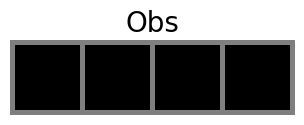

In [27]:
new_obs_imgs = torch.zeros_like(obs_imgs)
for idx, image in enumerate(obs_imgs):
    image = (image - image.min()) / (image.max() - image.min())
    new_obs_imgs[idx, ...] = image
    
show_imgs(obs_imgs, title='Obs')

In [29]:
print(obs_imgs.max(), obs_imgs.min())

tensor(-1., grad_fn=<MaxBackward1>) tensor(-1., grad_fn=<MinBackward1>)
